# Improved Mean Flow

**TL;DR:** This write-up presents the essential concepts and minimal code needed to understand the ideas behind the [Improved Mean Flow](https://arxiv.org/abs/2512.02012) (focusing only on the overall improvements in unconditional generation, up to Sec. 4.1).

Readers are assumed to be familiar with flow matching and mean flow.

The code follows the same style as the [flow matching](https://wenhangao21.github.io/blogs/files/g9_flow_matching/g9_flow_matching/)
and [mean flow](https://wenhangao21.github.io/blogs/files/g10_mean_flow/g10_mean_flow/) tutorials, using simple if–else statements to switch between
flow matching (FM), mean flow (MF), and improved mean flow (iMF) for easy transition and comparison.


If you have any questions or notice any errors, please contact [me](https://wenhangao21.github.io/).

## Initialization: Distributions

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import copy
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print("Using device:", device)

Using device: cpu


**Code:** We will use the standard Gaussian distribution as the source distribution and the “checkerboard distribution” as the target distribution. Let’s set up these two distributions.

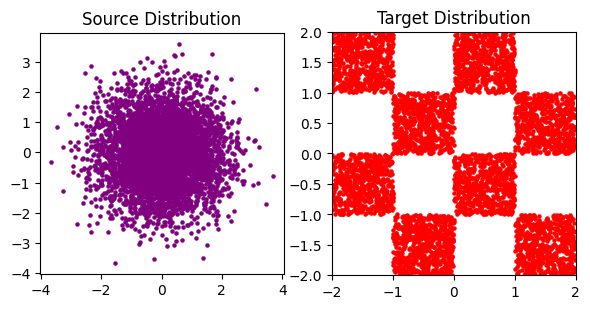

In [ ]:
def sample_checkerboard(N=1000, grid_size=4, scale=2.0):
    """
    Generate samples from a 2D checkerboard distribution.
    This function divides the square domain [-scale, scale] × [-scale, scale]
    into a grid of `grid_size × grid_size` equally sized square cells.
    """
    grid_length = 2 * scale / grid_size
    # Randomly choose integer tile coordinates
    gx = np.random.randint(0, grid_size, size=N)
    gy = np.random.randint(0, grid_size, size=N)
    mask = ((gx % 2) ^ (gy % 2)).astype(bool) # Keep only tiles where (even, odd) or (odd, even) — XOR rule
    while not np.all(mask): # Resample indices until all entries satisfy the checkerboard mask
        bad = np.where(~mask)[0]
        gx[bad] = np.random.randint(0, grid_size, size=len(bad))
        gy[bad] = np.random.randint(0, grid_size, size=len(bad))
        mask = ((gx % 2) ^ (gy % 2)).astype(bool)
    # Sample uniformly inside each chosen tile
    offsets = np.random.rand(N, 2) * grid_length
    xs = -scale + gx * grid_length + offsets[:, 0]
    ys = -scale + gy * grid_length + offsets[:, 1]
    return np.stack([xs, ys], axis=1).astype(np.float32)

def sample_pi_0(N=1000):
  return np.random.randn(N, 2).astype(np.float32)

def sample_pi_1(N=1000, grid_size=4, scale=2.0):
  return sample_checkerboard(N=N, grid_size=grid_size, scale=scale)

# Generate data
pi_0 = sample_pi_0(N=5_000)
grid_size, scale = 4, 2
pi_1 = sample_pi_1(N=5_000, grid_size=grid_size, scale=scale)
# Plot
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].scatter(pi_0[:, 0], pi_0[:, 1], c='purple', s=5)
axes[0].set_aspect('equal', 'box')
axes[0].set_title("Source Distribution")
axes[1].scatter(pi_1[:, 0], pi_1[:, 1], c='red', s=5)
axes[1].set_xlim(-scale, scale)
axes[1].set_ylim(-scale, scale)
axes[1].set_aspect('equal', 'box')
axes[1].set_title("Target Distribution")

plt.tight_layout()
plt.show()

## Background Information

Flow matching is introduced in this [tutorial](https://wenhangao21.github.io/blogs/files/g9_flow_matching/g9_flow_matching/); mean flow is introduced in this [tutorial](https://wenhangao21.github.io/blogs/files/g10_mean_flow/g10_mean_flow/).

- $\pi_0$: the source distribution
- $\pi_1$: the target distribution
- $X_0 \sim \pi_0$: random variables sampled from the source distribution
- $X_1 \sim \pi_1$: random variables sampled from the target distribution
- $\alpha_t=1-t$ and $\beta_t=t$: linear time schedule
- $X_t = t X_1+(1-t) X_0$: the flow interpolation
- $v_s\left(X_t, t\right) = X_1 - X_0$: the conditional velocity
- $\frac{d}{d t} X_t=v\left(X_t, t\right),t \in[0,1]$: the flow ODE
- $v\left(X_t, t\right)$: the marginal velocity
- $u(X_t, r, t) = \frac{1}{t - r} \int_{r}^{t} v(X_s, s) ds$: the average velocity over an interval $[r, t]$ with $t > r$
- $u(X_t, r, t)= v(X_t, t)-(t - r)\frac{d}{dt} u(X_t, r, t)$: mean flow identity


The flow matching objective is:

$$
\min _\theta \mathbb{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1, t\sim \text{Uniform}(0,1)}\left[\left\|v_s-v_\theta\left(X_t, t\right)\right\|^2\right].
$$

The mean flow objective is:

$$
\min _\theta  \mathbb{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1, r, t}\left[\left\| u_\theta\left(X_t, r, t\right) - \left(v_s - (t-r) \left[\frac{\partial u_\theta}{\partial X_t}, \frac{\partial u_\theta}{\partial r}, \frac{\partial u_\theta}{\partial t}\right] \cdot [v_s, 0,1] \right)\right\|^2\right] .
$$


## Mean Flow → Improved Mean Flow in One Line of Code

We first implement the improved mean flow by **adding only one line of code** from the original mean flow.

**Summary**: In mean flow, the average velocity $u$ is converted into an expression involving the instantaneous velocity $v$ and $\frac{du}{dt}$ for training with the network approximation $u_\theta$. However, $\frac{du_\theta}{dt}$ must be rewritten in terms of partial derivatives for Autograd, which introduces the term $\frac{dX_t}{dt} = v$, and this is replaced by the conditional velocity $v_s$ during training. This substitution is incorrect and leads to training issues. To mitigate this, the $v$ in $\frac{du_\theta}{dt}$ is replaced by the network’s approximation of the instantaneous velocity $u(X_t, t, t)$ instead.


The improved mean flow objective is:

$$
\min _\theta  \mathbb{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1, r, t}\left[\left\| u_\theta\left(X_t, r, t\right) - \left(v_s - (t-r) \left[\frac{\partial u_\theta}{\partial X_t}, \frac{\partial u_\theta}{\partial r}, \frac{\partial u_\theta}{\partial t}\right] \cdot [u_\theta(X_t, t, t), 0,1] \right)\right\|^2\right] .
$$

In [ ]:
class MLP(nn.Module):
    def __init__(self, in_dim=2, context_dim=2, h=128, out_dim=2):
        super(MLP, self).__init__()
        self.context_dim = context_dim
        self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h), nn.GELU(),
                                     nn.Linear(h, h), nn.GELU(),
                                     nn.Linear(h, h), nn.GELU(),
                                     nn.Linear(h, h), nn.GELU(),
                                     nn.Linear(h, out_dim))

    def forward(self, x, t, r=None):
      if r == None:
        return self.network(torch.cat((x, t), dim=1))
      else: # mean flow takes an additional time r
        return self.network(torch.cat((x, t, r), dim=1))


def train_flow(flow_model, n_iterations=5_001, lr=3e-3, batch_size=4096, save_freq=1_000, flow="FM", improved=True):
    print(f"Training {flow}")
    optimizer = torch.optim.Adam(flow_model.parameters(), lr=lr)
    losses = []
    checkpoints = []
    progress_bar = tqdm(range(n_iterations), desc="Training Flow Model", ncols=100)
    for iteration in progress_bar:
        x1 = torch.from_numpy(sample_pi_1(N=batch_size)).to(device)
        x0 = torch.from_numpy(sample_pi_0(N=batch_size)).to(device)
        if flow == "FM":
            t = torch.rand((x1.shape[0], 1), device=device) # randomly sample t
            x_t = t * x1 + (1.-t) * x0
            v = x1 - x0
            v_pred = flow_model(x_t, t)
            loss = torch.nn.functional.mse_loss(v_pred, v)
        elif flow == "MF":
            tr = torch.rand((x1.shape[0], 2), device=device)
            t = tr.max(dim=1, keepdim=True).values
            r = tr.min(dim=1, keepdim=True).values
            x_t = t * x1 + (1.-t) * x0
            v = x1 - x0   # conditional velocity given the end points
            dtdt, drdt = torch.ones_like(t), torch.zeros_like(r)
            # only changing the input to JVP for iMF; iMF: network velocity; MF: conditional velocity
            v_input = flow_model(x_t, t, t) if improved else v
            u_pred, dudt = torch.func.jvp(flow_model, (x_t, t, r), (v_input, dtdt, drdt))
            u_target = (v - (t - r) * dudt).detach()
            loss = torch.nn.functional.mse_loss(u_pred, u_target)
        else:
            raise NotImplementedError
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        progress_bar.set_postfix({"loss": f"{loss.item():.6f}"})
        if iteration % save_freq == 0:
          checkpoints.append({
              'iteration': iteration,
              'model_state_dict': copy.deepcopy(flow_model.state_dict()),
              'optimizer_state_dict': copy.deepcopy(optimizer.state_dict()),
              'loss': loss.item(),
          })
    if iteration % save_freq != 0:
      checkpoints.append({
          'iteration': iteration,
          'model_state_dict': copy.deepcopy(flow_model.state_dict()),
          'optimizer_state_dict': copy.deepcopy(optimizer.state_dict()),
          'loss': loss.item(),
      })
    return flow_model, losses, checkpoints

## Mean Flow: Training Objective

Start with the mean flow identity:

$$
\begin{aligned}
\underbrace{u(X_t, r, t)}_{\text{avg. vel.}}
    &= \underbrace{v(X_t, t)}_{\text{instant. vel.}}
       -
       (t - r) \underbrace{\frac{d}{dt} u(X_t, r, t)}_{\text{time derivative}}.
\end{aligned}
$$

**Note that autograd can only directly compute explicit (partial) derivatives, while the time derivative is implicit ($u$ is a functional of a function of $t$).** We apply multivariate chain rule:

$$\frac{d}{d t} u\left(X_t, r, t\right)=\frac{d X_t}{d t} \frac{\partial u}{\partial X_t}+\frac{d r}{d t}  \frac{\partial u}{\partial r}+\frac{d t}{d t}  \frac{\partial u}{\partial t},$$

where $\frac{d X_t}{d t} = v, \frac{d t}{d t} = 1$ and $\frac{d r}{d t} = 0$. This equation shows that the total derivative is given by the Jacobian-vector product (JVP) between $\left[\frac{\partial u}{\partial X_t}, \frac{\partial u}{\partial r}, \frac{\partial u}{\partial t}\right]$ (the Jacobian matrix of the function $u$ ) and the tangent vector $[v, 0,1]$. It can be efficiently computed by `torch.func.jvp` in PyTorch.

The training objective is:

$$
\min _\theta \mathbb{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1, r, t}\left[\left\| u_\theta\left(X_t, r, t\right) - \left(v(X_t, t) - (t-r) \left[\frac{\partial u}{\partial X_t}, \frac{\partial u}{\partial r}, \frac{\partial u}{\partial t}\right] \cdot [v(X_t, t), 0,1] \right)\right\|^2\right],
$$
where $r=\min \left(s_1, s_2\right), t=\max \left(s_1, s_2\right)$ with $s_1,s_2 \sim \text{Uniform (0,1)}$, $X_t=t X_1+(1-t) X_0$.

**In mean flow, both $v(X_t, t)$ are replaced with the conditional velocity given the end points $v_s=X_1-X_0$:**


$$
\min _\theta \mathbb{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1, r, t}\left[\left\| u_\theta\left(X_t, r, t\right) - \left(v_s - (t-r) \left[\frac{\partial u_\theta}{\partial X_t}, \frac{\partial u_\theta}{\partial r}, \frac{\partial u_\theta}{\partial t}\right] \cdot [v_s, 0,1] \right)\right\|^2\right] .
$$

**While replacing the first $v$ with $v_s$ is consistent with flow matching, replacing the second $v$ is not justified and leads to unstable training.**

## Mean Flow: Non-decreasing Loss with Large Variance

As discussed in the [mean flow tutorial](https://wenhangao21.github.io/blogs/files/g10_mean_flow/g10_mean_flow/), we do reverse training and integration.

In [ ]:
def sample_pi_1(N=1000):
  return np.random.randn(N, 2).astype(np.float32)

def sample_pi_0(N=1000, grid_size=4, scale=2.0):
  return sample_checkerboard(N=N, grid_size=grid_size, scale=scale)
# Generate data
grid_size, scale = 4, 2
pi_0 = sample_pi_0(N=5_000, grid_size=grid_size, scale=scale)

Let's train the mean velocity network $u_\theta$:

In [ ]:
MF_model_reverse = MLP(in_dim=2, context_dim=2, h=128, out_dim=2).to(device)
trained_model_MF_reverse, training_losses_MF_reverse, checkpoints_MF_reverse = train_flow(flow_model=MF_model_reverse, flow="MF", improved=False)

Training MF


Training Flow Model: 100%|███████████████████████| 5001/5001 [00:54<00:00, 91.73it/s, loss=3.089707]


Plot the losses:

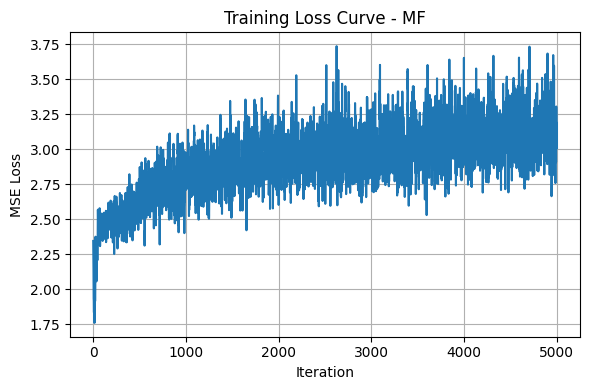

In [ ]:
losses = np.array(training_losses_MF_reverse)
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve - MF")
plt.grid(True)
plt.tight_layout()
plt.show()

The training is unstable; **the losses are non-decreasing and exhibit large variance**.

## Improved Mean Flow: Training Objective

Note that the mean flow identity can be rewritten as:

$$
\begin{aligned}
\underbrace{v(X_t, t)}_{\text{instant. vel.}}
    &= \underbrace{u(X_t, r, t)}_{\text{avg. vel.}}
       +
       (t - r) \underbrace{\frac{d}{dt} u(X_t, r, t)}_{\text{time derivative}}.
\end{aligned}
$$

In this view, if we parameterize $u$ with a neural network $u_\theta$, we can interpret the objective similar to a regular flow-matching loss that approximates the instantaneous velocity with a neural network:
$$
\mathcal{L}(\theta)=\mathbb{E}_{t, r, X_t}\left[\left\| v\left(X_t, t\right) - v_\theta\left(X_t, r, t\right)\right\|^2\right],
$$
where $v_\theta\left(X_t, r, t\right) = u_\theta\left(X_t, r, t\right)+(t-r) \frac{d}{d t} u_\theta\left(X_t, r, t\right)$.

Similar to regular flow matching, we replace the marginal velocity $v\left(X_t, t\right)$ with the conditional velocity $v_s = X_1-X_0$. However, in mean flow, $\frac{d u}{d t}$ is converted into explicit derivatives via JVP, **with a term involving the true marginal velocity $v$**, and this velocity is likewise replaced by the conditional velocity $v_s$ (see above) and "use as input to $v_\theta$". This leads to an issue:
- The regression target (the conditional velocity) is leaked as it is "used as input to $v_\theta$".
  - As the regression target is given, the network can simply be an identity function to minimize loss. However, the real regression target is not the conditional velocity, but the marginal velocity $v\left(X_t, t\right)=\mathbb{E}_{X_0, X_1 \mid X_t}\left[X_1 - X_0\right]$.

**To resolve this issue, we can use a neural network to learn the marginal velocity and be used in JVP. Notice that $u\left(X_t, t, t\right)=v\left(X_t, t\right)$. A simple approach is to use $u_\theta\left(Z_t, t, t\right)$ in the JVP instead of $v_s$.**


The improved mean flow objective is:

$$
\min _\theta  \mathbb{E}_{X_0 \sim \pi_0, X_1 \sim \pi_1, r, t}\left[\left\| u_\theta\left(X_t, r, t\right) - \left(v_s - (t-r) \left[\frac{\partial u_\theta}{\partial X_t}, \frac{\partial u_\theta}{\partial r}, \frac{\partial u_\theta}{\partial t}\right] \cdot [u_\theta(X_t, t, t), 0,1] \right)\right\|^2\right] .
$$

## Improved Mean Flow: More Stable Training

In [ ]:
iMF_model_reverse = MLP(in_dim=2, context_dim=2, h=128, out_dim=2).to(device)
trained_model_iMF_reverse, training_losses_iMF_reverse, checkpoints_iMF_reverse = train_flow(flow_model=iMF_model_reverse, flow="MF", improved=True)

Training MF


Training Flow Model: 100%|███████████████████████| 5001/5001 [00:52<00:00, 95.35it/s, loss=1.877170]


In [ ]:
FM_model_reverse = MLP(in_dim=2, context_dim=1, h=128, out_dim=2).to(device)
trained_model_FM_reverse, training_losses_FM_reverse, checkpoints_FM_reverse = train_flow(flow_model=FM_model_reverse, flow="FM")

Training FM


Training Flow Model: 100%|██████████████████████| 5001/5001 [00:34<00:00, 144.55it/s, loss=1.671618]


In [ ]:
def plot_three_losses(training_losses_FM, training_losses_MF, training_losses_iMF):
    """
    Plot loss curves for FM, MF, and iMF.
    """
    losses_list = [(np.array(training_losses_FM), "FM"),
        (np.array(training_losses_MF), "MF"),
        (np.array(training_losses_iMF), "iMF")]
    num_models = len(losses_list)
    fig_width = 4 * num_models
    fig_height = 3
    fig, axes = plt.subplots(1, num_models, figsize=(fig_width, fig_height))
    if num_models == 1:
        axes = [axes]
    for ax, (losses, name) in zip(axes, losses_list):
        ax.plot(losses)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("MSE Loss")
        ax.set_title(f"Training Loss — {name}")
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


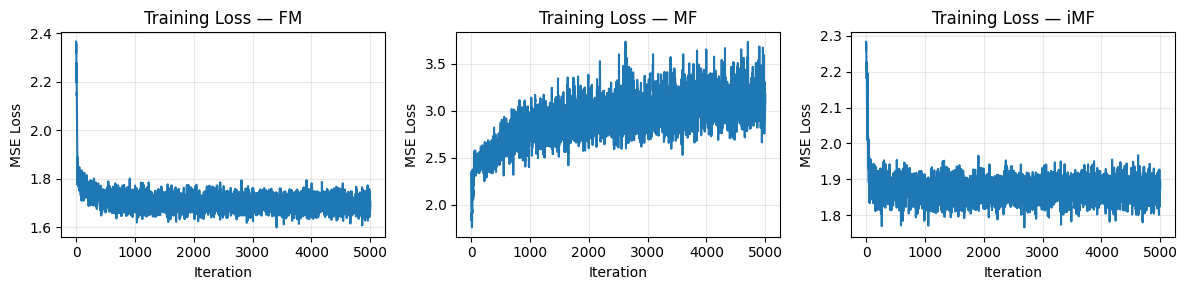

In [ ]:
plot_three_losses(training_losses_FM_reverse, training_losses_MF_reverse, training_losses_iMF_reverse)

## Additional Visualization

Generation is the same as in the [mean flow](https://wenhangao21.github.io/blogs/files/g10_mean_flow/g10_mean_flow/) tutorial.

### Generation Helper Functions

In [ ]:
def sample_flow(flow_model, N, T, flow="FM", reverse=True):
    """
    Sample from pi_0 (checkboard) with the flow model in T time steps.
    """
    x = torch.from_numpy(sample_pi_1(N=N)).to(device)
    dt = 1./T
    for i in (range(T)):
        if reverse: # time starts from 1
          t = torch.ones((x.shape[0], 1), device=x.device) * (1 - i * dt)
        else: # time starts from 0
          t = torch.ones((x.shape[0], 1), device=x.device) * (i * dt)
        if flow == "FM":
            pred = flow_model(x.squeeze(0), t) # predict v
        elif flow == "MF":
            r = t - dt
            pred = flow_model(x.squeeze(0), t, r) # predict u
        else:
            raise NotImplementedError
        x = x - pred * 1. / T if reverse else x + pred * 1. / T
    return x

In [ ]:
def sample_flow_xt(flow_model, N, T, num_xt, flow="FM", reverse=True):
    """
    Generate N samples from pi_1 with the flow model in T timesteps.
    Also save the sample X_t for intermidiate time between 0 and 1.
    """
    record_times = torch.linspace(0.0, 1.0, steps=num_xt).tolist()
    record_times = sorted(record_times)
    dt = 1.0 / T
    target_indices = {
        rt: int(round(rt / dt)) if not reverse else int(round((1 - rt) / dt))
        for rt in record_times
    }
    xt = {}
    x = torch.from_numpy(sample_pi_1(N=N)).to(device)
    # record starting state if needed
    if 0 in target_indices and not reverse:
        xt[0] = x.clone()
    if 1 in target_indices and reverse:
        xt[1] = x.clone()
    for i in range(T):
        if reverse:
            t = torch.ones((x.shape[0], 1), device=x.device) * (1 - i * dt)
        else:
            t = torch.ones((x.shape[0], 1), device=x.device) * (i * dt)
        if flow == "FM":
            pred = flow_model(x, t)
        elif flow == "MF":
            r = t - dt
            pred = flow_model(x, t, r)
        else:
            raise NotImplementedError
        x = x - pred * dt if reverse else x + pred * dt
        for rt, idx in target_indices.items():
            if idx == i + 1:
                xt[rt] = x.clone()

    return xt

### FM v.s. MF v.s. iMF: One-step and Multi-step Generation

In [ ]:
def visualize_three_models(FM_model, MF_model, iMF_model, N=2000, steps=[1, 10, 100, 500], reverse=True):
    """
    Visualize samples from FM, MF, and iMF models over different steps (T values).
    """
    num_rows = 3
    num_cols = len(steps)
    fig, axes = plt.subplots(num_rows, num_cols,
                             figsize=(3 * num_cols, 3 * num_rows))
    model_list = [(FM_model,  "FM"),
        (MF_model,  "MF"),
        (iMF_model, "iMF")]
    for row, (model, flow_name) in enumerate(model_list):
        for col, T in enumerate(steps):
            ax = axes[row, col]
            # Sample from the model
            flow_type = flow_name if flow_name != "iMF" else "MF"
            sampled = sample_flow(model, N=N, T=T, flow=flow_type, reverse=reverse)
            sampled = sampled.detach().cpu().numpy()
            # Plot target distribution (pi_1) and samples
            ax.scatter(pi_1[:, 0], pi_1[:, 1],
                       s=5, alpha=0.05, color='gray')
            ax.scatter(sampled[:, 0], sampled[:, 1],
                       s=5, alpha=0.3, color='red')
            ax.set_xlim(-3, 3)
            ax.set_ylim(-3, 3)
            ax.set_aspect("equal")
            ax.set_title(f"{flow_name}, T={T}")
            ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


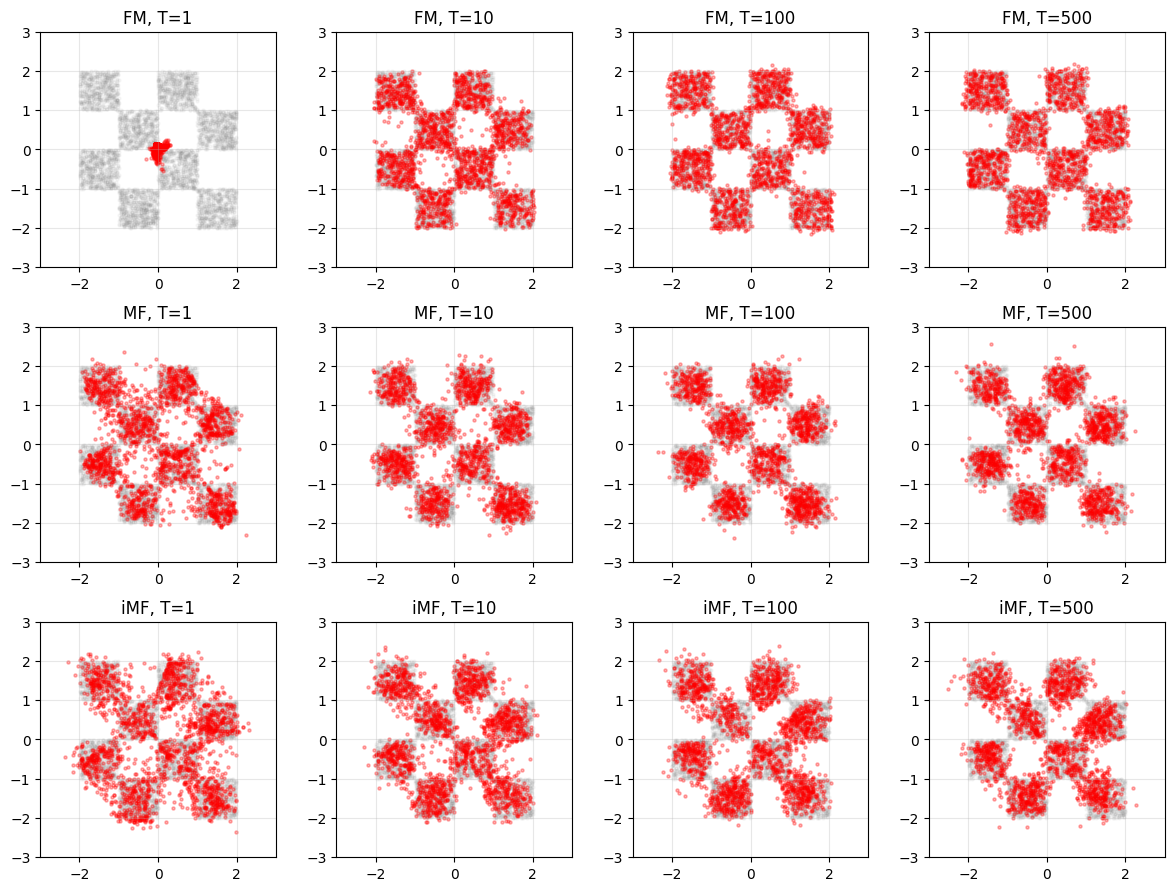

In [ ]:
visualize_three_models(trained_model_FM_reverse, trained_model_MF_reverse, trained_model_iMF_reverse, N=2000, steps=[1, 10, 100, 500], reverse=True)

### Evolution: $\pi_0$ to $\pi_1$

In [ ]:
def visualize_three_flows_xt(FM_model, MF_model, iMF_model, N, T, num_xt, max_cols=8, reverse=True):
    """
    Visualize intermediate X_t samples for three flow models: FM, MF, iMF.
    """
    # Sample intermediates X_t
    xt_FM  = sample_flow_xt(FM_model,  N=N, T=T, num_xt=num_xt, flow="FM",  reverse=reverse)
    xt_MF  = sample_flow_xt(MF_model,  N=N, T=T, num_xt=num_xt, flow="MF",  reverse=reverse)
    xt_iMF = sample_flow_xt(iMF_model, N=N, T=T, num_xt=num_xt, flow="MF", reverse=reverse)
    times_sorted = list(xt_FM.keys())   # same keys for all flows
    K = len(times_sorted)
    # Layout config
    cols = min(max_cols, K)
    rows_per_model = int(np.ceil(K / cols))
    total_rows = 3 * rows_per_model  # ★ three models now
    # Create figure and axes
    fig, axes = plt.subplots(total_rows, cols,
                             figsize=(2 * cols, 2 * total_rows))
    axes = axes.reshape(total_rows, cols)
    target = pi_0
    # Helper to fill one model block
    def fill_row_block(ax_block, xt_dict, model_name):
        idx = 0
        for i in range(ax_block.shape[0]):
            for j in range(ax_block.shape[1]):
                ax = ax_block[i, j]
                if idx < K:
                    t = times_sorted[idx]
                    xt = xt_dict[t].detach().cpu().numpy()

                    ax.scatter(target[:, 0], target[:, 1],
                               s=1, alpha=0.05, color='gray')
                    ax.scatter(xt[:, 0], xt[:, 1],
                               s=3, alpha=0.4, color='red')

                    ax.set_xlim(-3, 3)
                    ax.set_ylim(-3, 3)
                    ax.set_aspect('equal')
                    ax.grid(True, alpha=0.3)
                    ax.set_title(f"{model_name} | t={t:.2f}")
                else:
                    ax.axis("off")
                idx += 1
    # Fill row blocks for the three models
    fill_row_block(axes[0:rows_per_model],                    xt_FM,  "FM")
    fill_row_block(axes[rows_per_model:2*rows_per_model],     xt_MF,  "MF")
    fill_row_block(axes[2*rows_per_model:3*rows_per_model],   xt_iMF, "iMF")

    plt.tight_layout()
    plt.show()

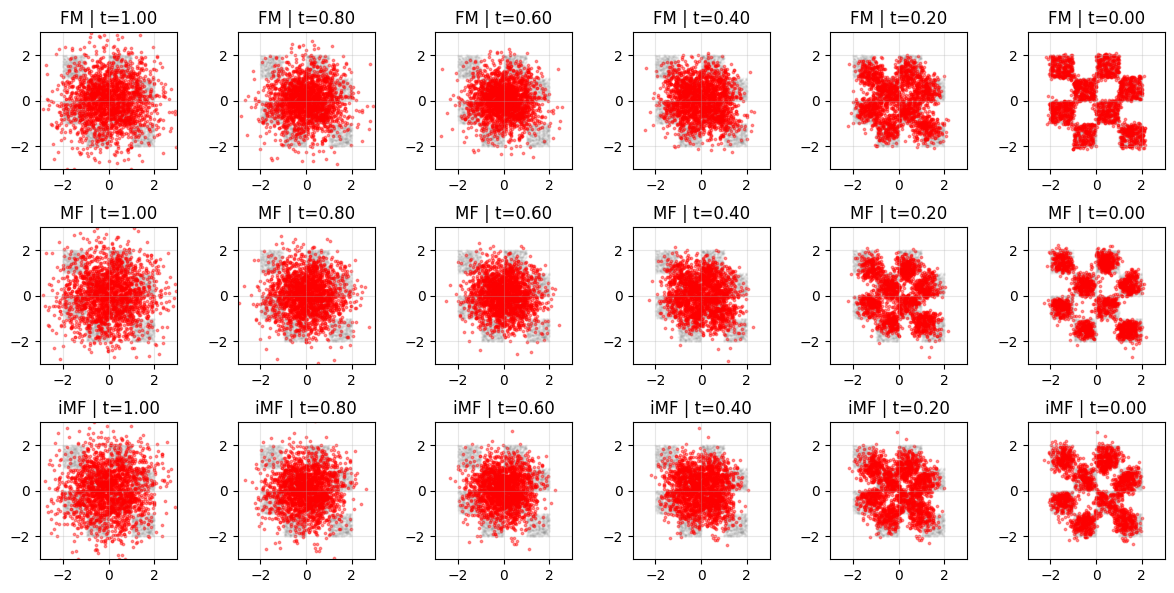

In [ ]:
visualize_three_flows_xt(FM_model=trained_model_FM_reverse,
                          MF_model=trained_model_MF_reverse,
                          iMF_model=trained_model_iMF_reverse,
                          N=2000,
                          T=100,
                          num_xt=6,
                          max_cols=8,
                          reverse=True)

### Samping at Different Training Stages

In [ ]:
def visualize_all_checkpoints_three_models(
    flow_model_FM, checkpoints_FM,
    flow_model_MF, checkpoints_MF,
    flow_model_iMF, checkpoints_iMF,
    N, T, max_cols=4, reverse=True):
    """
    Plot sampling for three models (FM, MF, iMF).
    """
    num_plots = max(len(checkpoints_FM),
                    len(checkpoints_MF),
                    len(checkpoints_iMF))
    cols = min(max_cols, num_plots)
    rows = 3  # FM row, MF row, iMF row
    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    # Ensure axes is 2D
    if rows == 1:
        axes = axes[np.newaxis, :]
    # ------------------------------------------------
    # Helper to plot one entire row of checkpoints
    # ------------------------------------------------
    def plot_model_row(ax_row, model, checkpoints, flow, reverse):
        for col in range(cols):
            ax = ax_row[col]
            if col < len(checkpoints):
                checkpoint = checkpoints[col]
                iteration = checkpoint["iteration"]
                # Load state
                model.load_state_dict(checkpoint["model_state_dict"])
                # Sample from model
                flow_type = flow if flow != "iMF" else "MF"
                sampled = sample_flow(model, N=N, T=T,
                                      flow=flow_type, reverse=reverse)
                sampled = sampled.detach().cpu().numpy()
                # Background target (pi_1)
                ax.scatter(pi_1[:, 0], pi_1[:, 1],
                           s=1, alpha=0.05, color="gray")
                # Sampling result
                ax.scatter(sampled[:, 0], sampled[:, 1],
                           s=3, alpha=0.3, color="red")
                ax.set_xlim(-3, 3)
                ax.set_ylim(-3, 3)
                ax.set_aspect("equal")
                ax.set_title(f"{flow} — ite={iteration}")
                ax.grid(True, alpha=0.3)
            else:
                ax.axis("off")
    # -------------------------------
    # Fill rows for the three models
    # -------------------------------
    # FM in row 0
    plot_model_row(axes[0], flow_model_FM,  checkpoints_FM,  "FM",  reverse)
    # MF in row 1
    plot_model_row(axes[1], flow_model_MF,  checkpoints_MF,  "MF",  reverse)
    # iMF in row 2
    plot_model_row(axes[2], flow_model_iMF, checkpoints_iMF, "iMF", reverse)
    plt.tight_layout()
    plt.show()


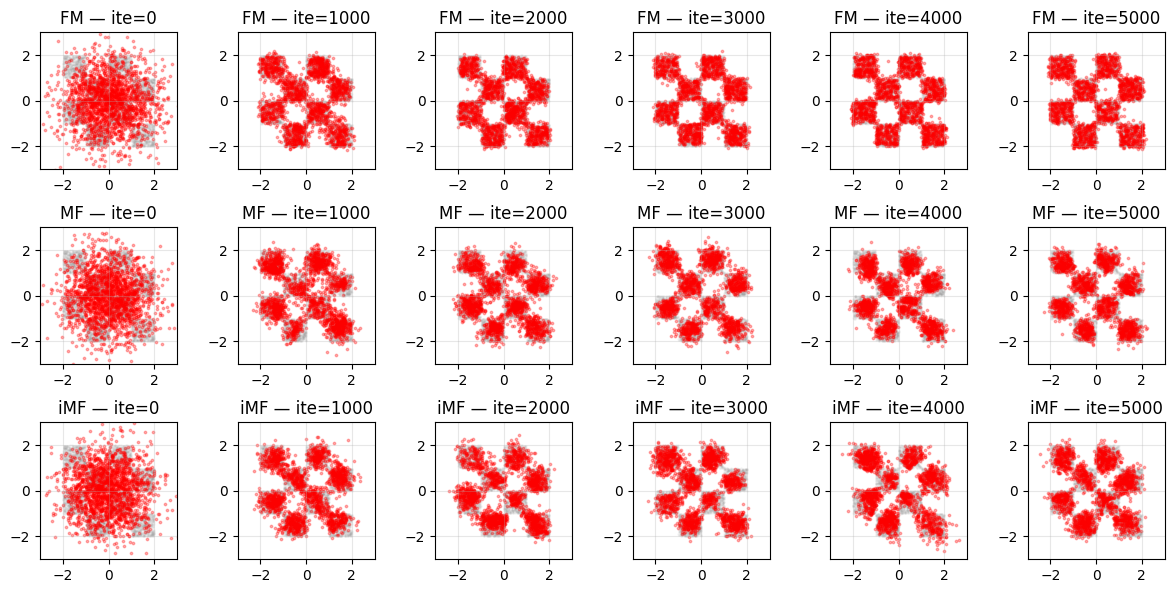

In [ ]:
visualize_all_checkpoints_three_models(
    flow_model_FM=trained_model_FM_reverse, checkpoints_FM=checkpoints_FM_reverse,
    flow_model_MF=trained_model_MF_reverse, checkpoints_MF=checkpoints_MF_reverse,
    flow_model_iMF=trained_model_iMF_reverse, checkpoints_iMF=checkpoints_iMF_reverse,
    N=2000, T=100, max_cols=6, reverse=True)